##### I want to scrape and analyze the data from fictional online book store: http://books.toscrape.com/
##### I need to gather the following information about all the products of the website: book name, price, availability, category, rating

In [1]:
import requests#allows to send access requests to website easily
import re #a Python’s standard library, can be used to check if a string contains the specified search pattern
import pandas as pd#handles extracted data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
import plotly.express as ex
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.patches as mpatches
from warnings import filterwarnings
sns.set_style('whitegrid')

In [2]:
from bs4 import BeautifulSoup#pulls data out of HTML files

In [3]:
main_url = "http://books.toscrape.com/index.html"#Let's identify the target website's address (URL)
result = requests.get(main_url)#creating a response object to get the web page's HTML content
soup = BeautifulSoup(result.text, 'html.parser')#creating a beautiful soup object to parse HTML text with the help of the html.parser
print(soup.prettify()[:1000])#function prettify() makes HTML more readable

<!DOCTYPE html>
<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!-->
<html class="no-js" lang="en-us">
 <!--<![endif]-->
 <head>
  <title>
   All products | Books to Scrape - Sandbox
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="24th Jun 2016 09:29" name="created"/>
  <meta content="" name="description"/>
  <meta content="width=device-width" name="viewport"/>
  <meta content="NOARCHIVE,NOCACHE" name="robots"/>
  <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
  <!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
  <link href="static/oscar/favicon.ico" rel="shortcut icon"/>
  <link href="static/oscar/css/styles.css" rel="stylesheet" type="tex

In [4]:
#Let’s define a function to request and parse HTML web page because we will need this later
def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

In [5]:
#Let`s take a look on our first product URL with BeautifulSoup
soup.find("article", class_ = "product_pod").div.a.get('href')

'catalogue/a-light-in-the-attic_1000/index.html'

In [6]:
#With findAll() function we may get all the products URLs on the main page
main_page_products_urls = [x.div.a.get('href') for x in soup.findAll("article", class_ = "product_pod")]

print(str(len(main_page_products_urls)) + " products URLs")
print("One example:")
main_page_products_urls[0]

20 products URLs
One example:


'catalogue/a-light-in-the-attic_1000/index.html'

In [7]:
def getBooksURLs(url):
    soup = getAndParseURL(url)
    # remove the index.html part of the base url before returning the results
    return(["/".join(url.split("/")[:-1]) + "/" + x.div.a.get('href') for x in soup.findAll("article", class_ = "product_pod")])


In [8]:
# store all the results into a list
pages_urls = [main_url]

soup = getAndParseURL(pages_urls[0])

# while we get two matches, this means that the webpage contains a 'previous' and a 'next' button
# if there is only one button, this means that we are either on the first page or on the last page
# we stop when we get to the last page

while len(soup.findAll("a", href=re.compile("page"))) == 2 or len(pages_urls) == 1:
    
    # get the new complete url by adding the fetched URL to the base URL (and removing the .html part of the base URL)
    new_url = "/".join(pages_urls[-1].split("/")[:-1]) + "/" + soup.findAll("a", href=re.compile("page"))[-1].get("href")
    
    # add the URL to the list
    pages_urls.append(new_url)
    
    # parse the next page
    soup = getAndParseURL(new_url)
    

print(str(len(pages_urls)) + " URLs")
print("Examples:")
pages_urls[:5]

50 URLs
Examples:


['http://books.toscrape.com/index.html',
 'http://books.toscrape.com/catalogue/page-2.html',
 'http://books.toscrape.com/catalogue/page-3.html',
 'http://books.toscrape.com/catalogue/page-4.html',
 'http://books.toscrape.com/catalogue/page-5.html']

Let's fetch all the products URLs for every page and iterate through the pages and apply our function:

In [9]:
booksURLs = []
for page in pages_urls:
    booksURLs.extend(getBooksURLs(page))
    
print(str(len(booksURLs)) + " fetched URLs")
print("Some examples:")
booksURLs[:5]

1000 fetched URLs
Some examples:


['http://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html',
 'http://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html',
 'http://books.toscrape.com/catalogue/soumission_998/index.html',
 'http://books.toscrape.com/catalogue/sharp-objects_997/index.html',
 'http://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html']

We got the 1000 book URLs. As much as it said on the website!
The last step is to scrap the data for each product.

In [10]:
names = []
prices = []
amount_in_stock = []
categories = []
ratings = []

# scrape data for every book URL: this may take some time
for url in booksURLs:
    soup = getAndParseURL(url)
    # product name
    names.append(soup.find("div", class_ = re.compile("product_main")).h1.text)
    # product price
    prices.append(soup.find("p", class_ = "price_color").text[2:]) # get rid of the pound sign
    # number of available products
    amount_in_stock.append(re.sub("[^0-9]", "", soup.find("p", class_ = "instock availability").text)) # get rid of non numerical characters
    # product category
    categories.append(soup.find("a", href = re.compile("../category/books/")).get("href").split("/")[3])
    # ratings
    ratings.append(soup.find("p", class_ = re.compile("star-rating")).get("class")[1])

In [11]:
# add data into pandas df
import pandas as pd

data = pd.DataFrame({'name': names, 'price': prices, 'amount_in_stock': amount_in_stock, "product_category": categories, "rating": ratings})
data.head(10)

,name,price,amount_in_stock,product_category,rating
0,A Light in the Attic,51.77,22,poetry_23,Three
1,Tipping the Velvet,53.74,20,historical-fiction_4,One
2,Soumission,50.10,20,fiction_10,One
3,Sharp Objects,47.82,20,mystery_3,Four
4,Sapiens: A Brief History of Humankind,54.23,20,history_32,Five
5,The Requiem Red,22.65,19,young-adult_21,One
6,The Dirty Little Secrets of Getting Your Dream...,33.34,19,business_35,Four
7,The Coming Woman: A Novel Based on the Life of...,17.93,19,default_15,Three
8,The Boys in the Boat: Nine Americans and Their...,22.60,19,default_15,Four
9,The Black Maria,52.15,19,poetry_23,One


Now we got our dataframe! Let's explore it!

In [12]:
data.shape

(1000, 5)

In [13]:
data.describe()

,name,price,amount_in_stock,product_category,rating
count,1000,1000,1000,1000,1000
unique,999,903,21,50,5
top,The Star-Touched Queen,27.88,3,default_15,One
freq,2,3,196,152,226


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              1000 non-null   object
 1   price             1000 non-null   object
 2   amount_in_stock   1000 non-null   object
 3   product_category  1000 non-null   object
 4   rating            1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [15]:
data['price'] = pd.to_numeric(data['price'])#turn catecorial data to numerical

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1000 non-null   object 
 1   price             1000 non-null   float64
 2   amount_in_stock   1000 non-null   object 
 3   product_category  1000 non-null   object 
 4   rating            1000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 39.2+ KB


In [17]:
data['product_category'].unique()

array(['poetry_23', 'historical-fiction_4', 'fiction_10', 'mystery_3',
       'history_32', 'young-adult_21', 'business_35', 'default_15',
       'sequential-art_5', 'music_14', 'science-fiction_16',
       'politics_48', 'travel_2', 'thriller_37', 'food-and-drink_33',
       'romance_8', 'childrens_11', 'nonfiction_13', 'art_25',
       'spirituality_39', 'philosophy_7', 'new-adult_20',
       'contemporary_38', 'fantasy_19', 'add-a-comment_18', 'science_22',
       'health_47', 'horror_31', 'self-help_41', 'religion_12',
       'christian_43', 'crime_51', 'autobiography_27',
       'christian-fiction_34', 'biography_36', 'womens-fiction_9',
       'erotica_50', 'cultural_49', 'psychology_26', 'humor_30',
       'historical_42', 'novels_46', 'short-stories_45', 'suspense_44',
       'classics_6', 'academic_40', 'sports-and-games_17',
       'adult-fiction_29', 'parenting_28', 'paranormal_24'], dtype=object)

In [18]:
data.product_category.value_counts()

default_15              152
nonfiction_13           110
sequential-art_5         75
add-a-comment_18         67
fiction_10               65
young-adult_21           54
fantasy_19               48
romance_8                35
mystery_3                32
food-and-drink_33        30
childrens_11             29
historical-fiction_4     26
classics_6               19
poetry_23                19
history_32               18
horror_31                17
womens-fiction_9         17
science-fiction_16       16
science_22               14
music_14                 13
business_35              12
thriller_37              11
philosophy_7             11
travel_2                 11
humor_30                 10
autobiography_27          9
art_25                    8
psychology_26             7
religion_12               7
christian-fiction_34      6
spirituality_39           6
new-adult_20              6
self-help_41              5
biography_36              5
sports-and-games_17       5
health_47           

In [19]:
data.groupby('rating').count()

,name,price,amount_in_stock,product_category
rating,,,,
Five,196,196,196,196
Four,179,179,179,179
One,226,226,226,226
Three,203,203,203,203
Two,196,196,196,196


In [20]:
cleanup_nums = {"rating": {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}}#Let`s replace categorial data in rating

In [21]:
data = data.replace(cleanup_nums)

In [22]:
data.head()

,name,price,amount_in_stock,product_category,rating
0,A Light in the Attic,51.77,22,poetry_23,3
1,Tipping the Velvet,53.74,20,historical-fiction_4,1
2,Soumission,50.10,20,fiction_10,1
3,Sharp Objects,47.82,20,mystery_3,4
4,Sapiens: A Brief History of Humankind,54.23,20,history_32,5


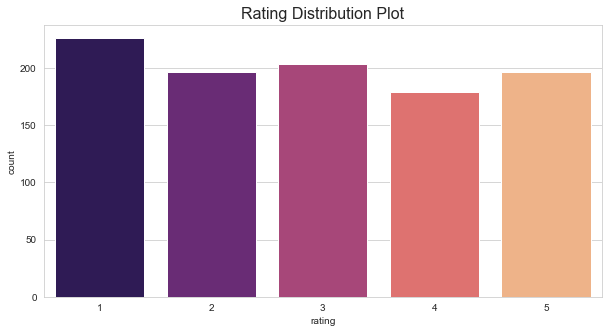

In [23]:
#let's analize rating distrbution
plt.figure(figsize=(10,5))
sns.countplot(x=data['rating'],palette='magma')
plt.title('Rating Distribution Plot',fontsize=16)
plt.show()

C:\Users\Acer\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


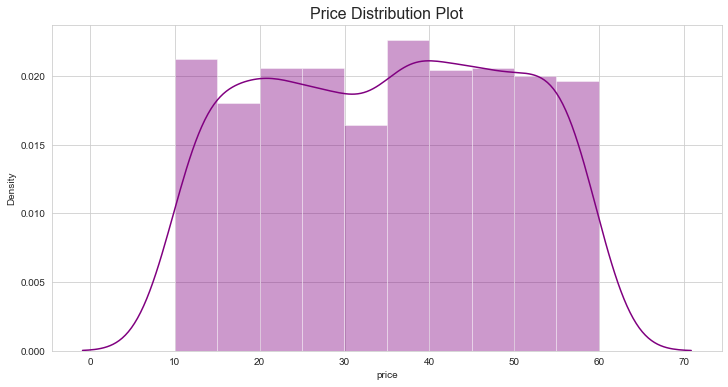

In [24]:
#let's analize price distrbution
plt.figure(figsize=(12,6))
sns.distplot(data['price'],color='purple')
plt.title('Price Distribution Plot',fontsize=16)
plt.show()
filterwarnings('ignore')

Data is not distributed normally due to artificially created dataset/

In [38]:
#We may check Proportion Of Different Categories
fig = ex.pie(data,names='product_category',title='Proportion Of Different Categories in the Dataset',hover_data=['product_category'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [39]:
#Another price distribution analysis
fig = px.histogram(data, x= 'price', title='Price', marginal="box", hover_data = data[['name']])
fig.show()

As we see median price is 35.98, q1-q3=22.105-47.475

In [40]:
#Let's find the most popular categories
common_books=data['product_category'].value_counts()[:7].rename_axis('Common Books').reset_index(name='count')
fig = px.treemap(common_books, path=['Common Books'], values='count',title='TOP 7 CATEGORIES')

fig.show()

In [41]:
#TOP 10 books with highest prices
temp_df1 = data.groupby('name').mean().reset_index().sort_values('price',ascending=False).head(10)
trace1 = go.Bar(
                x = temp_df1['name'],
                y = temp_df1['price'],
                marker = dict(color = 'rgb(28,6,64)',
                             line=dict(color='rgb(62,173,172)',width=1.9)))
layout = go.Layout(template= "plotly_white",title = 'TOP 10 BOOKS WITH HIGHEST PRICES' , xaxis = dict(title = 'Name'), yaxis = dict(title = 'Price'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()

Despite the fact it was a small fictional dataset we got some useful information!   